In [48]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import sys
import sklearn
sys.path.append('../Utils')
sys.path.append('..ata')
#import torch


from my_utils_Velo import *

from utils import *
import scipy
import matplotlib.pyplot as plt
#import test_batch_modules
#from test_batch_modules import batch_test, OT_lagged_correlation, load_others_result, batch_test_BEELINE, load_others_result_BEELINE
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read the single-cell data from xlsx file and get all gene names

In [49]:
df = pd.read_excel('../Data/single_cell_kouno_data.xlsx')
gene_names_all = list(df.columns)
gene_names_all = gene_names_all[0:-2]
print(gene_names_all)

['BCL6', 'CBFB', 'CEBPB', 'CEBPD', 'EGR2', 'ELK1', 'ETS1', 'FLI1', 'FOS', 'FOSB', 'HOXA10', 'HOXA13', 'IRF8', 'JUN', 'KLF10', 'KLF13', 'LMO2', 'MAFB', 'MYB', 'MYEF2', 'NFATC1', 'NFATC2', 'NFE2L1', 'NFYA', 'NFYC', 'PPARD', 'PPARG', 'PRDM1', 'RREB1', 'RUNX1', 'RXRB', 'SMAD3', 'SMAD4', 'SNAI1', 'SNAI3', 'SP3', 'SPI1', 'SPIB', 'STAT1', 'TCF3', 'TCFL5', 'TFPT', 'TRIM28', 'UHRF1']


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


These are the genes that people have ground truth for:

In [50]:
idx_genes = [1 ,3,  4  ,   5  ,   8  ,  11  ,  12   , 13  ,  18  ,  19  ,  21  ,  23  ,  26   , 27  ,  28  ,  30  ,  35 ,41 ,   42 ,   44]
idx_genes = np.array(idx_genes) - 1
gene_names = []
for i in idx_genes:
    #print(i)
    gene_names = gene_names + [gene_names_all[i]]

Create labels and concatenate count matrices

In [51]:

counts = np.array(df)
counts = counts[:,0:-2]
counts = np.array(counts,dtype=float)
counts = counts.T
#counts  = counts[idx_genes, :]

    
group_labels = [0,1,6,12,24,48,72,96]
Nt = len(group_labels)
stages = df.h
groups = [[]]*Nt



for j in range(len(group_labels)):
    groups[j] = []
    for i in range(len(stages)):
    
        if stages[i] == group_labels[j]:
            groups[j] += [i]
            
counts_all = [[0]]*Nt

labels = np.zeros((1,counts.shape[1]))
num_start = 0
for j in range(len(group_labels)):
    counts_all[j] = []
    counts_all[j] = np.array(counts[:,groups[j]],dtype=float)
    num_end = num_start + len(groups[j])
    
    labels[0,num_start:num_end] = j
    
    num_start = num_end

labels = labels[:,0:num_end]

counts = counts_all[0]
for j in range(Nt-1):
    counts = np.concatenate( (counts, counts_all[j+1] ), axis=1 )



Visualize the matrices. Top: all cells across all time points. Bottom: breakdown according to time.

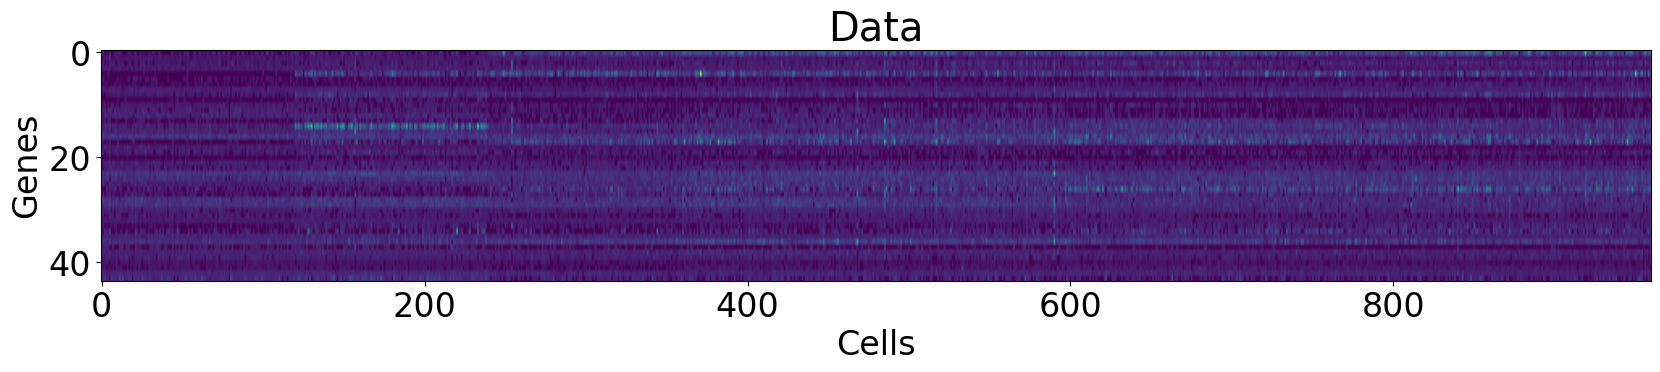

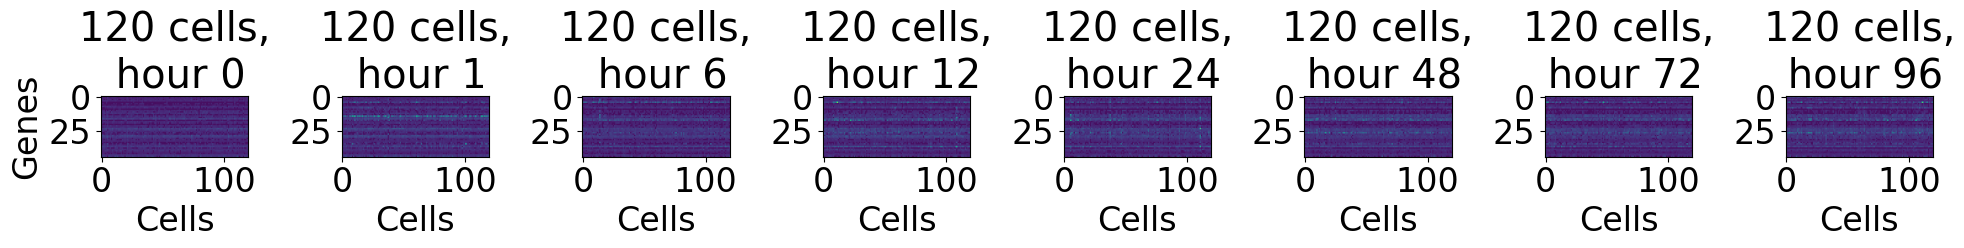

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["font.size"] = 24
plt.imshow(np.array(counts,dtype=float),aspect='auto' )
plt.title('Data')
plt.xlabel('Cells')
plt.ylabel('Genes')
plt.show()



for i in range(len(group_labels)):
    plt.subplot(1,Nt,i+1)
    plt.imshow(counts_all[i], aspect='auto')
    plt.title(str(counts_all[i].shape[1])+' cells,\n hour '+str(group_labels[i]) )
    plt.xlabel('Cells')
    if i == 0:
        plt.ylabel('Genes')
    plt.clim([0,counts.max()])
plt.tight_layout()
plt.show()

Here we compute PCA and visualize the first 2 PCs according to time:

In [53]:
#plt.rcParams["figure.figsize"] = (8,5)
counts_pca,pca = visualize_pca(counts,labels,group_labels,viz_opt='pca')


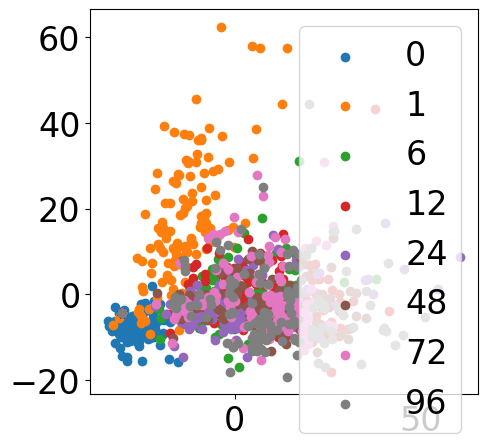

In [68]:
for i in range(Nt):
    idx = np.where( labels == i )
    plt.scatter( counts_pca[idx,0], counts_pca[idx,1], label=group_labels[i])
plt.legend()

Solve OT here:

In [54]:

eps_samp = 1e-2       
Ts_prior,_ = solve_prior(counts,counts, Nt, labels, eps_samp=eps_samp, alpha=0.5)


(120, 44)
(120, 44)


/opt/anaconda3/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(120, 44)


/opt/anaconda3/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(120, 44)


/opt/anaconda3/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(120, 44)
(120, 44)
(120, 44)


Visualize cells and their descendents through time

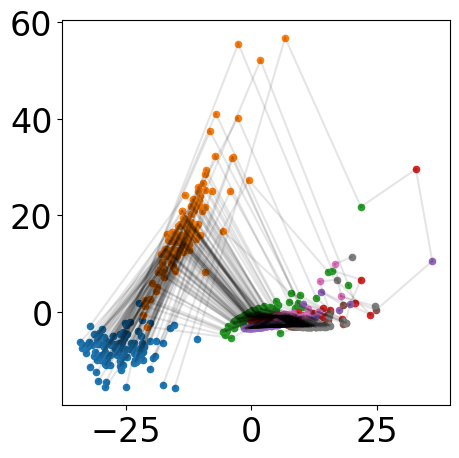

In [55]:
new_counts, new_counts_pca = visualize_cell_path(counts, counts_all, group_labels, Ts_prior )
# plt.savefig('Figures/path_bifurcate.eps', format='eps')


Print the non-uniform time points

In [59]:
group_labels

[0, 1, 6, 12, 24, 48, 72, 96]

These are delta t -- gaps in time grid

In [57]:
dt = [1,5,6,12,24,24,24]

Now compute velocities! 

In [58]:
# Infer velocity?
# Infer velocity
from utils_Velo import solve_velocities
velocities_all, velocities_all_signed = solve_velocities( counts_all, Ts_prior, dt=dt,order=1)



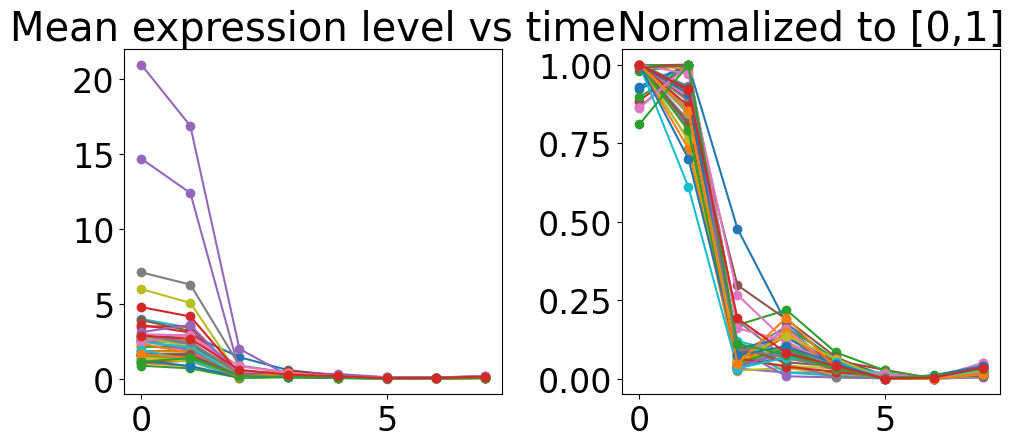

array([[2.71228186e+00, 1.04923118e+00, 1.83691229e+00, 1.06467454e+00,
        1.46920306e+01, 2.61311187e+00, 1.61003286e+00, 1.55331115e+00,
        5.98194111e+00, 3.98386466e+00, 1.55942312e+00, 2.90396876e+00,
        1.41181872e+00, 3.48216173e+00, 2.09743167e+01, 3.91157676e+00,
        2.16644041e+00, 7.10017167e+00, 1.46928158e+00, 2.84301555e+00,
        2.61704426e+00, 1.82320554e+00, 2.13797586e+00, 3.59446856e+00,
        2.53288604e+00, 1.58905125e+00, 2.97530639e+00, 2.53617521e+00,
        2.79939600e+00, 2.45636301e+00, 1.69166537e+00, 2.33924019e+00,
        8.66379113e-01, 4.77682515e+00, 3.10775974e+00, 1.60054360e+00,
        2.49158388e+00, 2.85835999e+00, 1.32818598e+00, 1.93586448e+00,
        1.19855741e+00, 1.63229190e+00, 1.12312767e+00, 2.88100999e+00],
       [2.93845296e+00, 8.35434158e-01, 1.87630319e+00, 1.19949553e+00,
        1.24009450e+01, 2.32664355e+00, 1.48552252e+00, 1.27877665e+00,
        5.05989623e+00, 3.40195179e+00, 1.67257709e+00, 2.49181

In [20]:
from utils_Velo import vis_mean_level
vis_mean_level(velocities_all)

In [21]:
s = []
for i in range(Nt):
    s = s + [counts_all[i].shape[1]]
s_cum = list(np.cumsum(s))
s_cum = [0] + s_cum

In [22]:
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (5,5)
n = counts_all[0].shape[0]
velocities = np.zeros( (n, counts.shape[1]))
velocities_signed = np.zeros( (n, (counts.shape[1])))

for i in range(Nt):
    
    velocities[:,s_cum[i]:s_cum[i+1] ] = velocities_all[i]
    velocities_signed[:,s_cum[i]:s_cum[i+1]] = velocities_all_signed[i]
    

In [23]:
idx_genes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

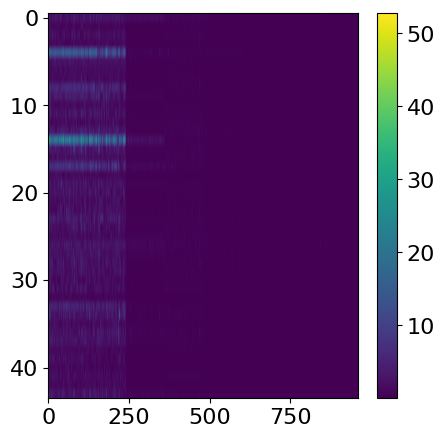

In [24]:

plt.imshow( velocities, aspect='auto')
plt.colorbar()


In [25]:
idx_genes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

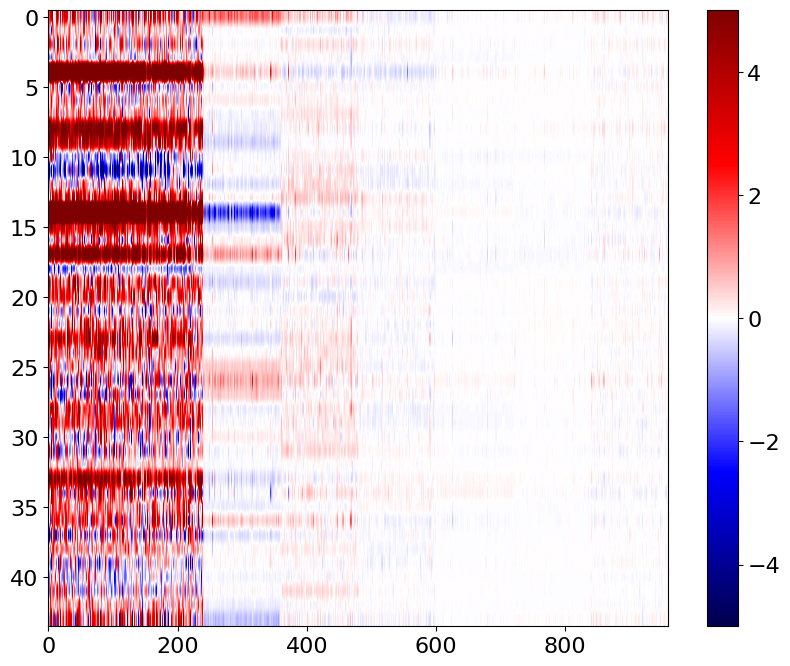

In [26]:
plt.rcParams["figure.figsize"] = (10,8)
if velocities_signed.shape[0] == 44:
    plt.imshow( velocities_signed[idx_genes,:], aspect='auto',cmap='seismic')
else:
    plt.imshow( velocities_signed, aspect='auto',cmap='seismic')
    plt.yticks(range(len(idx_genes)),gene_names)
plt.clim([-5,5])
plt.colorbar()
plt.show()

In [27]:
num_cells_per_step = 120

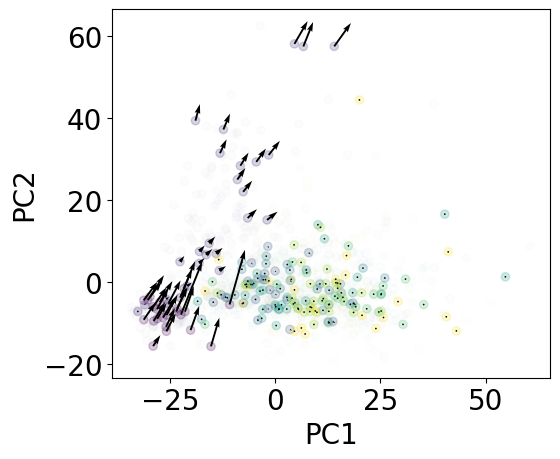

In [28]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["font.size"] = 20
velocities_all_pca = [ [0] ]*(Nt)
nums = []
for i in range(Nt):
    nums = nums + [ counts_all[i].shape[1] ]
      

i = 0
velocities_all_pca[i] = [0]
count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
    
velocities_all_pca[i] = (pca.transform( count_t_mapped.T ) - pca.transform( counts_all[i].T ))/dt[i]


for i in range(1,Nt-1):
    velocities_all_pca[i] = [0]
    count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
    
    velocities_all_pca[i] = pca.transform( count_t_mapped.T ) - pca.transform( counts_all[i].T )
    count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
    velocities_all_pca[i] = velocities_all_pca[i]/2/dt[i] + (pca.transform( counts_all[i].T ) - pca.transform( count_t_mapped.T ))/2/dt[i-1]
   
i = Nt-1

count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
velocities_all_pca[i] = ( pca.transform(counts_all[i].T) - pca.transform( count_t_mapped.T ) )/dt[i-1]

velocities_pca = np.zeros( (n, (Nt)*num_cells_per_step))

for i in range(Nt):
    
    velocities_pca[:,i*num_cells_per_step:(i+1)*num_cells_per_step] = velocities_all_pca[i].T

plt.scatter(counts_pca[:,0], counts_pca[:,1],c=labels, alpha=0.01 )
# plt.colorbar()
# velocities_pca = pca.transform( velocities_signed.T)
Num_cell = counts_pca.shape[0]
idx_subsamp = range(0,Num_cell,5)
plt.scatter(counts_pca[idx_subsamp,0], counts_pca[idx_subsamp,1],c=labels[0][idx_subsamp], alpha=0.2 )
plt.quiver( counts_pca[idx_subsamp,0],counts_pca[idx_subsamp,1],velocities_pca[0,idx_subsamp] , velocities_pca[1,idx_subsamp], scale=500 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
#plt.savefig('../Results/Kouno/velocity_Kouno.pdf',dpi=1000)
# plt.show()

Compute our correlation and/or Granger causality via LASSO

In [29]:
Tv_corr, OT_corr_slice = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, stimulation=False, return_slice=True )

In [30]:
Tv_l1 = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, signed=True, alpha_opt=1.0,elastic_Net=True, l1_opt=1.0, tune=False )

In [31]:
#Tv_tune = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, signed=True, elastic_Net=True, l1_opt=1.0, tune=True )

In [33]:
#plt.imshow(Tv_l1)

Now start to compare with truth

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score

In [35]:
if counts.shape[0] < 44:
    idx_genes = list( range( counts.shape[0]) )
else:
    idx_genes = [1 ,3,  4  ,   5  ,   8  ,  11  ,  12   , 13  ,  18  ,  19  ,  21  ,  23  ,  26   , 27  ,  28  ,  30  ,  35 ,41 ,   42 ,   44]
    idx_marker = list( np.array( idx_genes )-1 )
    idx_genes = idx_marker
idx = np.ix_(idx_marker, idx_marker)
len(idx_marker)

20

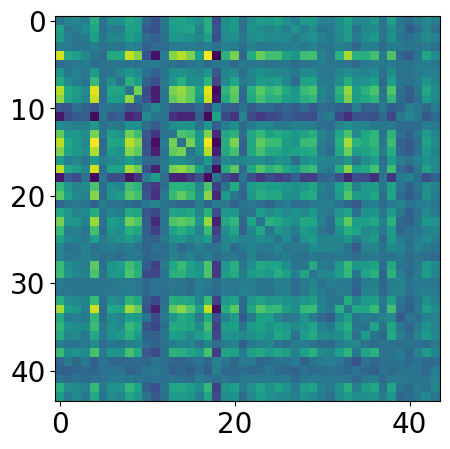

In [37]:
plt.imshow(Tv_corr - np.diag( np.diag(Tv_corr)))

In [30]:

from evaluation_metrics import signed_AUPRC

In [69]:


import scipy.io
truth = scipy.io.loadmat('../Data/result_SINCERITIES_signed.mat')
truth = truth['adj_ref']

Tv_true_flattened = []
n = truth.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_true_flattened += [truth[i,j]]

Tv_true_flattened = np.array( Tv_true_flattened ) 


#sign = 'signed'
sign = None
option = 'corr'#
#option = 'l1'


if option == 'l1':
    Tv_total = Tv_l1

elif option == 'corr':
    Tv_total = Tv_corr

else:
    Tv_total = Tv_tune

Tv_total_small = Tv_total[ np.ix_(idx_genes,idx_genes)]
Tv_total_flattened = []

n = Tv_total_small.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_total_flattened += [Tv_total_small[i,j]]

Tv_total_flattened = np.array( Tv_total_flattened )
if sign == 'pos':
    Tv_total_flattened = Tv_total_flattened * (Tv_total_flattened>0)
    Tv_true_flattened = Tv_true_flattened * (Tv_true_flattened>0)
elif sign == 'neg':
    Tv_total_flattened = -Tv_total_flattened * (Tv_total_flattened<0)
    Tv_true_flattened = -Tv_true_flattened * (Tv_true_flattened<0)
elif sign == None:
    Tv_total_flattened = abs( np.array( Tv_total_flattened ) )
    Tv_true_flattened = abs( np.array( Tv_true_flattened ) )
else:
    print('blabla')

if sign == None:
    precision, recall, _ = precision_recall_curve( Tv_true_flattened,Tv_total_flattened) 
    print('AUPRC='+str( auc( recall, precision) )  )
    print('AUROC='+str(roc_auc_score( abs(Tv_true_flattened), abs(Tv_total_flattened) ) ) )
else:
    auprc, auroc = signed_AUPRC( Tv_total_flattened, Tv_true_flattened)  
    print('AUPRC='+str( auprc ) )
    print('AUROC='+str( auroc ) )
# Tv_small_total[0] = Tv_small_total[0]/Tv_small_total[0].max()

#print( np.sum(np.array(Tv_total_flattened_signed)*np.array( Tv_true_flattened_signed)>0) )

AUPRC=0.29372262893596796
AUROC=0.5961067119155354


Visualize truth vs our matrix for closer comparison:

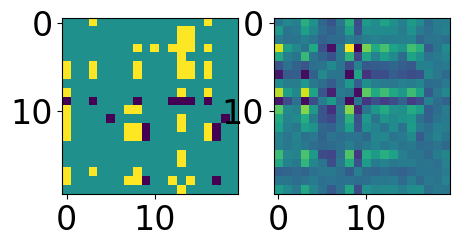

In [70]:
plt.subplot(1,2,1)
plt.imshow( truth )
plt.subplot(1,2,2)
plt.imshow( Tv_total_small - np.diag( np.diag(Tv_total_small)) )
#plt.clim([-.5,.5])

In [47]:
Tv_sin = scipy.io.loadmat('../Data/result_SINCERITIES_signed.mat')

In [48]:
Tv_sin = Tv_sin['adj_matrix']

In [40]:
#Tv_sin

In [39]:
Tv_true_flattened

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [104]:
sign = 'signed'
import scipy.io
truth = scipy.io.loadmat('../Data/result_SINCERITIES_signed.mat')
truth = truth['adj_ref']
Tv_sin = scipy.io.loadmat('../Data/result_SINCERITIES_signed.mat')
Tv_sin = Tv_sin['adj_matrix']

Tv_true_flattened = []
n = truth.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_true_flattened += [truth[i,j]]

Tv_true_flattened = np.array( Tv_true_flattened ) 

Tv_total_flattened = []

n = Tv_total_small.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_total_flattened += [Tv_sin[i,j]]

Tv_total_flattened = np.array( Tv_total_flattened )
if sign == 'pos':
    Tv_total_flattened = Tv_total_flattened * (Tv_total_flattened>0)
    Tv_true_flattened = Tv_true_flattened * (Tv_true_flattened>0)
elif sign == 'neg':
    Tv_total_flattened = -Tv_total_flattened * (Tv_total_flattened<0)
    Tv_true_flattened = -Tv_true_flattened * (Tv_true_flattened<0)
elif sign == None:
    Tv_total_flattened = abs( np.array( Tv_total_flattened ) )
    Tv_true_flattened = abs( np.array( Tv_true_flattened ) )


if sign == None:
    precision, recall, _ = precision_recall_curve( Tv_true_flattened,Tv_total_flattened) 
    print('AUPRC='+str( auc( recall, precision) )  )
    print('AUROC='+str(roc_auc_score( abs(Tv_true_flattened), abs(Tv_total_flattened) ) ) )
else:
    auprc, auroc = signed_AUPRC( Tv_sin, truth)  
    print('AUPRC='+str( auprc ) )
    print('AUROC='+str( auroc ) )


blabla
AUPRC=0.20382966561714186
AUROC=0.6064962724284444


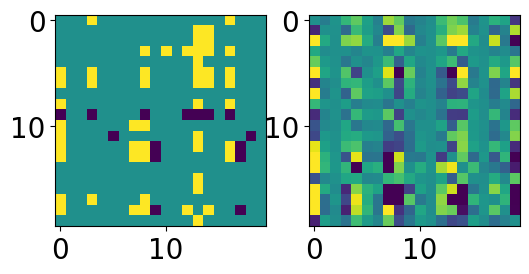

In [105]:
plt.subplot(1,2,1)
plt.imshow( truth )
plt.subplot(1,2,2)
plt.imshow( Tv_sin)
plt.clim([-.5,.5])

In [106]:
sign = None
import scipy.io
truth = scipy.io.loadmat('../Results/Kouno/result_SINCERITIES_signed.mat')
truth = truth['adj_ref']
Tv_GENIE3 = scipy.io.loadmat('../Results/Kouno/result_Kouno_GENIE3.mat')
Tv_GENIE3 = Tv_GENIE3['VIM']
Tv_GENIE3 = Tv_GENIE3[ np.ix_(idx_genes, idx_genes)]

Tv_true_flattened = []
n = truth.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_true_flattened += [truth[i,j]]

Tv_true_flattened = np.array( Tv_true_flattened ) 

Tv_total_flattened = []

n = Tv_total_small.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_total_flattened += [Tv_GENIE3[i,j]]

Tv_total_flattened = np.array( Tv_total_flattened )
if sign == 'pos':
    Tv_total_flattened = Tv_total_flattened * (Tv_total_flattened>0)
    Tv_true_flattened = Tv_true_flattened * (Tv_true_flattened>0)
elif sign == 'neg':
    Tv_total_flattened = -Tv_total_flattened * (Tv_total_flattened<0)
    Tv_true_flattened = -Tv_true_flattened * (Tv_true_flattened<0)
elif sign == None:
    Tv_total_flattened = abs( np.array( Tv_total_flattened ) )
    Tv_true_flattened = abs( np.array( Tv_true_flattened ) )
else:
    for i in range(len(Tv_total_flattened)):
        if Tv_total_flattened[i]*Tv_true_flattened[i] < 0:
            Tv_total_flattened[i] = 0
    Tv_total_flattened = abs( np.array( Tv_total_flattened ) )
    Tv_true_flattened = abs( np.array( Tv_true_flattened ) )
    
precision, recall, _ = precision_recall_curve( Tv_true_flattened,Tv_total_flattened) 
print('AUPRC='+str( auc( recall, precision) )  )
# Tv_small_total[0] = Tv_small_total[0]/Tv_small_total[0].max()
print('AUROC='+str(roc_auc_score( Tv_true_flattened, Tv_total_flattened) ) )
#print( np.sum(np.array(Tv_total_flattened_signed)*np.array( Tv_true_flattened_signed)>0) )

AUPRC=0.2560774962418524
AUROC=0.4704939668174962


In [51]:
sign = 'signed'
import scipy.io
truth = scipy.io.loadmat('../Results/Kouno/result_SINCERITIES_signed.mat')
truth = truth['adj_ref']
Tv_HARISSA = np.load('../Results/Kouno/Kouno_CARDAMOM.npy')
Tv_HARISSA = Tv_HARISSA[1:,1:]
Tv_HARISSA = Tv_HARISSA[ np.ix_(idx_genes, idx_genes)]

Tv_true_flattened = []
n = truth.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_true_flattened += [truth[i,j]]

Tv_true_flattened = np.array( Tv_true_flattened ) 

Tv_total_flattened = []

n = Tv_total_small.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_total_flattened += [Tv_HARISSA[i,j]]

Tv_total_flattened = np.array( Tv_total_flattened )
if sign == 'pos':
    Tv_total_flattened = Tv_total_flattened * (Tv_total_flattened>0)
    Tv_true_flattened = Tv_true_flattened * (Tv_true_flattened>0)
elif sign == 'neg':
    Tv_total_flattened = -Tv_total_flattened * (Tv_total_flattened<0)
    Tv_true_flattened = -Tv_true_flattened * (Tv_true_flattened<0)
elif sign == None:
    Tv_total_flattened = abs( np.array( Tv_total_flattened ) )
    Tv_true_flattened = abs( np.array( Tv_true_flattened ) )
else:
    
    print('blabla')

if sign == None:
    precision, recall, _ = precision_recall_curve( Tv_true_flattened,Tv_total_flattened) 
    print('AUPRC='+str( auc( recall, precision) )  )
    print('AUROC='+str(roc_auc_score( abs(Tv_true_flattened), abs(Tv_total_flattened) ) ) )
else:
    auprc, auroc = signed_AUPRC( Tv_total_flattened, Tv_true_flattened)
    print('AUPRC='+str( auprc )  )
    
    print('AUROC='+str(auroc))
# Tv_small_total[0] = Tv_small_total[0]/Tv_small_total[0].max()

#print( np.sum(np.array(Tv_total_flattened_signed)*np.array( Tv_true_flattened_signed)>0) )

blabla
AUPRC=0.12635153606312588
AUROC=0.39339222186921335


In [39]:
#idx_genes

In [38]:
# for i in range(3):
#     plt.subplot(3,1,i+1)
#     plt.imshow(np.random.rand(3,3)-0.5,cmap='seismic')
#     plt.xticks([])
#     plt.yticks([])
#     plt.clim([-1,1])